<a href="https://colab.research.google.com/github/rbarman/lfa/blob/master/w2/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 28.0 MB/s 
     |████████████████████████████████| 4.7 MB 64.3 MB/s 
     |████████████████████████████████| 1.3 MB 62.1 MB/s 
     |████████████████████████████████| 365 kB 74.7 MB/s 
     |████████████████████████████████| 141 kB 76.3 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 212 kB 76.8 MB/s 
     |████████████████████████████████| 115 kB 76.9 MB/s 
     |████████████████████████████████| 596 kB 56.7 MB/s 
     |████████████████████████████████| 127 kB 70.9 MB/s 
     |████████████████████████████████| 6.6 MB 62.0 MB/s 
Mounted at /content/gdrive


# Build Dataset

In [2]:
from fastai.vision.all import Image
from fastai.vision.utils import verify_images, get_image_files
from fastai.vision.utils import download_images
from fastai.vision.utils import resize_images
from fastbook import search_images_ddg
from pathlib import Path
import random

In [3]:
def build_img_dataset_from_ddg(search_queries: str, resize_size: int=400) -> Path:

    # Classification classes
    # search_queries = 'elephant','rhino'

    # Paths to store downloaded and resized images
    downloaded_path = Path("downloaded_imgs")
    resized_path = Path("resized_imgs")

    # For each query:
    # - search for images with duckduckgo
    # - download the images
    # - resize the images
    for sq in search_queries:
        dest = (downloaded_path/sq)
        dest.mkdir(exist_ok=True, parents=True)
        urls = search_images_ddg(sq).items
        download_images(dest, urls=urls)
        resize_images(downloaded_path/sq, max_size=resize_size, dest=resized_path/sq)


    failed = verify_images(get_image_files(resized_path))
    failed.map(Path.unlink)
    #len(failed)

    return resized_path

In [4]:
# Classification classes
search_queries = 'elephant','rhino'
root_path = build_img_dataset_from_ddg(search_queries)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
!ls {root_path}

elephant  rhino


# Create DataLoader

We will use the data block API

In [6]:
from fastai.vision.all import *
# TODO: tighten up imports

In [7]:
my_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # labels item with parent folder name
    get_y=parent_label, 
    # Random resize crop transformation on each item
    # On each epoch (which is one complete pass through all of our images in the dataset) 
    # we randomly select a different part of each image. 
    # This means that our model can learn to focus on, and recognize, different features in our images. 
    # It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.
    item_tfms=RandomResizedCrop(128, min_scale=0.3),
)

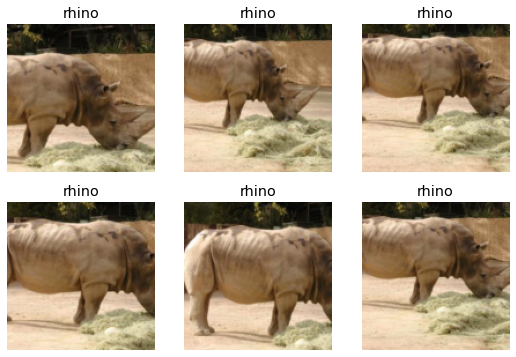

In [8]:
# We can see the random resize crop in action for one image: 
dls = my_datablock.dataloaders(root_path)
dls.show_batch(max_n=6,unique=True)


In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # labels item with parent folder name
    get_y=parent_label, 
    # Random resize crop transformation on each item
    # On each epoch (which is one complete pass through all of our images in the dataset) 
    # we randomly select a different part of each image. 
    # This means that our model can learn to focus on, and recognize, different features in our images. 
    # It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.
    item_tfms=RandomResizedCrop(128, min_scale=0.3),
    # On each batch of images, perform augmentations
    batch_tfms=aug_transforms()
).dataloaders(root_path)

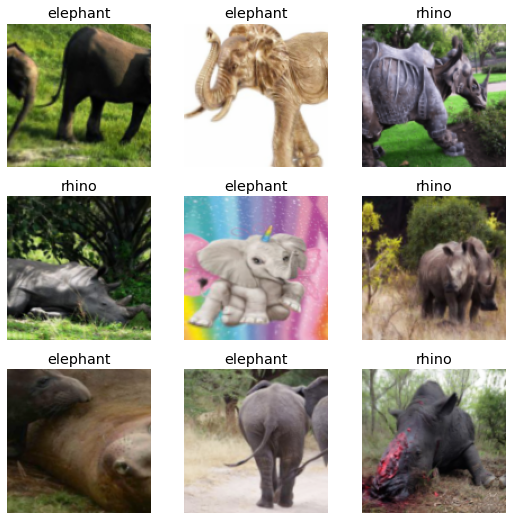

In [10]:
dls.show_batch()

Some images have cars in them. Due to the random resized crop, the network might only see a car... This may be a problem

# Initial Model
- Transfer learning with resnet18. Use a FastAI learner

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.060950,0.722095,0.171053,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.750424,0.515972,0.131579,00:02
1,0.617779,0.526650,0.118421,00:01
2,0.536612,0.451504,0.118421,00:01
3,0.470176,0.403307,0.092105,00:01


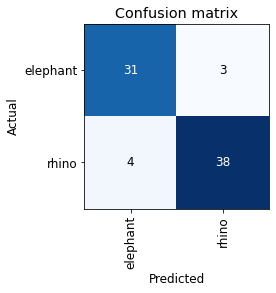

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Confusion matrix shows good results. Only few false predictions

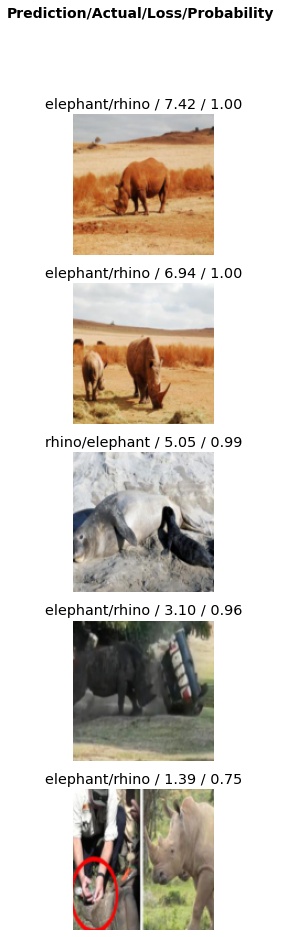

In [13]:
# Identify images with highest loss
interp.plot_top_losses(5, nrows=5)

Some images may not be elephant/rhino or may be difficult for a human to understand.

We can use the ImageClassifierCleaner to remove 'bad' images

# Image Clean up

In [14]:
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: ignored

# Export

Export the learner to be used in other applications

In [15]:
learn.export('model.pkl')

In [16]:
!ls *.pkl

model.pkl


# Infer

In [17]:
learn_inf = load_learner('model.pkl')

In [18]:
learn_inf.dls.vocab

['elephant', 'rhino']

In [19]:
from fastdownload import download_url


In [20]:
def get_test_img(query: str,filename:str):
    test_url = search_images_ddg(query,max_images=1).items[0]
    download_url(test_url, filename, show_progress=False)
    return filename

In [21]:
elephant_test_img = get_test_img('elephant photo', 'elephant.jpg')

In [22]:
predicted_class, _, probs = learn_inf.predict(elephant_test_img)

print(f'Final prediction: {predicted_class}')
for i,c in enumerate(learn_inf.dls.vocab):
    print(f'\t{c} with {probs[i]} probability')


Final prediction: elephant
	elephant with 1.0 probability
	rhino with 4.836229550164717e-08 probability
